# Transfer Learning for NLP: Sentiment Analysis on Twitter
This notebook has used the "Transfer Learning in NLP" Feedlys' [notebook](https://github.com/feedly/ml-demos/blob/master/source/TransferLearningNLP.ipynb) described in this [article](https://blog.feedly.com/transfer-learning-in-nlp) as starting point.

In this notebook, we show how transfer learning can be applied to detecting the sentiment of twitter posts related to Tesla, between bulls and bears.

This notebook uses the work from [Howard and Ruder, Ulmfit](https://arxiv.org/pdf/1801.06146.pdf).
The idea of the paper (and it implementation explained in the [fast.ai deep learning course](http://course.fast.ai/lessons/lesson10.html)) is to learn a language model trained on a very large dataset, e.g. a Wikipedia dump. The intuition is that if a model is able to predict the next word at each word, it means it has learnt something about the structure of the language we are using.

[Word2vec](https://arxiv.org/pdf/1310.4546.pdf) and the likes have lead to huge improvements on various NLP tasks. This could be seen as a first step to transfer learning, where the pre-trained word vectors correspond to a transfer of the embedding layer.
The ambition of [Ulmfit](https://arxiv.org/pdf/1801.06146.pdf) (and others like [ELMO](https://arxiv.org/pdf/1802.05365.pdf) or the [Transformer language model](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf) recently introduced) is to progressively move the NLP field to the state where Computer Vision has risen thanks to the ImageNet challenge. Thanks to the ImageNet chalenge, today it is easy to download a model pre-trained on massive dataset of images, remove the last layer and replace it by a classifier or a regressor depending on the interest. 

With Ulmfit, the goal is for everyone to be able to use a pre-trained language model and use it a backbone which we can use along with a classifier and a regressor. The game-changing apect of transfer learning is that we are no longer limited by the size of trzining data! With only a fraction of the data size that was necessary before, we can trtain a classifier/regressor and have very good result with few labelled data.

Given that labelled text data are difficult to get, in comparison with unlabelled text data which is almost infinite, transfer learning is likely to change radically the field of NLP, and help lead to a maturity state closer to computyer vision.

The architecture for the language model used in ULMFit is the [AWD-LSTM language model](https://arxiv.org/pdf/1708.02182.pdf) by Merity.

While we are using this language model for this experiment, we keep an eye open to a recently proposed character language model with [Contextual String Embedings](http://alanakbik.github.io/papers/coling2018.pdf) by Akbik.

# Content of this notebook

The data consists of around 150K Twitter posts that are either bullish or bearish. Training a model, with the whole training labelled dataset (150K Twitter posts) and our classifier results in a f1 score of 0.90.

Note that if you are interested in Regression instead of classification, you can also do it following this [advice](http://forums.fast.ai/t/regression-using-ulmfit/18063/6).

The notebook is organized as such:

- Tokenize the reviews and create dictionaries
- Download a pre-trained model and link the dictionary to the embedding layer of the model
- Fine-tune the language model on the amaxon reviews texts

We have then the backbone of our algorithm: a pre-trained language model fine-tuned on Twitter posts

- Add a classifier to the language model and train the classifier layer only
- Gradually defreeze successive layers to train different layers on the Twitter posts
- Run a full classification task for several epochs
- Use the model for inference!

We end this notebook by looking at the specific effect of training size on the overall performance. This is to test the hypothesis that the ULMFit model does not need much labeled data to perform well.

# Data

Also, we recommend working on a dedicated environment (e.g. mkvirtualenv fastai). Then clone the fastai github repo https://github.com/fastai/fastai and install requirements.

In [1]:
# ! pip install fastai==0.7
# ! pip install --force-reinstall Pillow==5.0.0
# ! pip install opencv-python
# ! apt update && apt install -y libsm6 libxext6

In [2]:
# ! conda install -y spacy

In [3]:
# ! python -m spacy download en

In [4]:
#! ln -s "$root_path" ./data

In [5]:
#! mkdir "$path"

In [1]:
from fastai.text import *
from fastai.lm_rnn import *
import html
import os
import pandas as pd
import pickle
import re
import preprocessor as p
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, \
confusion_matrix
from sklearn.model_selection import train_test_split
from time import time

In [2]:
pd.options.display.float_format = '{:.6f}'.format
pd.options.display.max_colwidth = 400
p.set_options(p.OPT.URL, p.OPT.MENTION)

In [3]:
# root_path = '/home/ubuntu/data'
# root_path = '/home/paperspace/data'
# root_path = '/Users/Miguel/git/data'
# path = './data/stocktwits_posts'
path = './data/twitter'
# data_file_nonextension_name = 'twitter_posts_preprocessed_20180420_20180913'
data_file_nonextension_name = 'twitter_posts_post_enriched_20180901_20180918'
data_file = f'{path}/{data_file_nonextension_name}.json.gz'

# PREPARE DATASETS

In [4]:
re1 = re.compile(r'  +')

def fixup(x):
    x = p.clean(x)
    
    x = x.replace('&#', "#").replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [5]:
df_clean_twitter_posts = pd.read_json(
    data_file, 
    orient='records', 
    lines=True, compression='gzip'
)



In [6]:
df_clean_twitter_posts['repeat']=(df_clean_twitter_posts['impact']/100 + 1).astype(np.int32)

In [7]:
df_clean_repeated_twitter_posts = pd.DataFrame(
    np.repeat(df_clean_twitter_posts.values, df_clean_twitter_posts['repeat'].tolist(), axis=0),
                                 columns=df_clean_twitter_posts.columns)# .reset_index()

In [8]:
label_cases = {
    'Bullish': 1,
    'Bearish': 0,
}

def calculate_numeric_label(text_label):
    return label_cases[text_label]

In [9]:
df_clean_repeated_twitter_posts['labels'] = df_clean_repeated_twitter_posts['sentiment'].apply(lambda text_label: calculate_numeric_label(text_label))

In [10]:
df_clean_repeated_twitter_posts = df_clean_repeated_twitter_posts.rename({'clean_body': 'text'}, axis='columns')

In [11]:
df_clean_repeated_twitter_posts[['text', 'sentiment', 'labels', 'sentiment_vader_normalized']].head()

,text,sentiment,labels,sentiment_vader_normalized
0,"RT : I hope sues the shorts for defamation. We have so many witneses and screenshots, I wouldnt mind seeing some of…",Bullish,1,0.720000
1,RT : You mean like when that dum dum bragged about Tesla only hitting their end of Q2 M3 production goa…,Bullish,1,0.680000
2,RT : All $tslaq short shorts tweets and interactions adamantly believe that company Q3 update is a lie ! Cars are not produced or…,Bullish,1,0.500000
3,"RT : After waiting 2.5 years, it’s finally happening! $TSLA $TSLAQ",Bullish,1,0.500000
4,RT : $TSLAQ going apeshit because founder and CEO of twitter endorsed interview with . Funniest thing I'v…,Bullish,1,0.790000


In [12]:
print(df_clean_repeated_twitter_posts.index)

RangeIndex(start=0, stop=38219, step=1)


In [13]:
df_twitter_posts = df_clean_repeated_twitter_posts.query('labels!=2').reset_index(drop=True)

In [14]:
print(df_twitter_posts.index)

RangeIndex(start=0, stop=38219, step=1)


# TRAIN/TEST

In [15]:
def train_validate_test_split(df, train_percent=.75, validate_percent=0, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [16]:
train, _, test = train_validate_test_split(df_twitter_posts)

In [17]:
print(f'The train data contains {len(train)} examples')
print(f'The test data contains {len(test)} examples')

The train data contains 28664 examples
The test data contains 9555 examples


In [18]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path(path)

CLAS_PATH=PATH/'twitter_posts_class'
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=PATH/'twitter_posts_lm'
LM_PATH.mkdir(exist_ok=True)

In [19]:
df_trn = train[['labels','text']]
df_val = test[['labels','text']]

In [20]:
df_trn.head(10)

,labels,text
37453,1,But but this is violence 😁😁❤️
223,0,A…
32975,1,Getting juiced up for the weekend! #TexasEV #Supercharging teslamotors Tesla
7222,0,"RT : The counter thesis to $TSLA longs' ""have you even driven one bro?"" is looking pretty good $TSLAQ"
8140,0,"Doesn't Bernstein know that new $TSLA mngt will reset the guidance && probably issue restated financials, esp in reg…"
3087,0,How many car companies convince their customers to travel long distances to purchase their cars? Seems insane. $tsla
20858,1,RT : Electric cars made with sunlight
37682,1,Thank you for making #dearMoon possible!
9050,0,Which day of these weeks do we expect the pump of the month namely leaking the #Autocrash update release date? $TSLAQ #countdownto🍋💩🎪💥
24330,1,RT : Electric cars made with sunlight


In [21]:
# df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
# df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

df_trn.to_json(
    f'{CLAS_PATH}/{data_file_nonextension_name}_train.json.gz', 
    orient='records', 
    lines=True, compression='gzip'
)

df_val.to_json(
    f'{CLAS_PATH}/{data_file_nonextension_name}_test.json.gz', 
    orient='records', 
    lines=True, compression='gzip'
)


In [22]:
CLASSES = ['Bearish', 'Bullish']
(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in CLASSES)

# Language Model

In [23]:
df_trn['labels'] = 0
df_val['labels'] = 0

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
# We're going to fine tune the language model so it's ok to take some of the test set in our train data
# for the lm fine-tuning
# df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
# df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

df_trn.to_json(
    f'{LM_PATH}/{data_file_nonextension_name}_train.json.gz', 
    orient='records', 
    lines=True, compression='gzip'
)

df_val.to_json(
    f'{LM_PATH}/{data_file_nonextension_name}_test.json.gz', 
    orient='records', 
    lines=True, compression='gzip'
)

In [25]:
df_trn = pd.read_json(
    f'{LM_PATH}/{data_file_nonextension_name}_train.json.gz', 
    orient='records', 
    lines=True, compression='gzip'
)# [['text', 'labels']]

df_val = pd.read_json(
    f'{LM_PATH}/{data_file_nonextension_name}_test.json.gz', 
    orient='records', 
    lines=True, compression='gzip'
)

for i, r in enumerate(df_val):
    print(f'{i}:{r}')


0:labels
1:text


In [26]:
chunksize=6000

In [27]:
# Here we use functions from the fast.ai course to get data
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    # print(df[n_lbls])
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): 
        texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        df = r.rename(columns={x:y for x,y in zip(r.columns,range(0,len(r.columns)))})
        # print(r)
        tok_, labels_ = get_texts(df, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

# df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
# df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

df_trn = pd.read_json(
    f'{LM_PATH}/{data_file_nonextension_name}_train.json.gz', 
    orient='records', 
    lines=True, compression='gzip', chunksize=chunksize
)# [['text', 'labels']]

df_val = pd.read_json(
    f'{LM_PATH}/{data_file_nonextension_name}_test.json.gz', 
    orient='records', 
    lines=True, compression='gzip', chunksize=chunksize
)# [['text', 'labels']]



In [28]:
print(type(df_val))

<class 'pandas.io.json.json.JsonReader'>


In [29]:
# This cell can take quite some time if your dataset is large
# Run it once and comment it for later use
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
4
0
1


In [30]:
# Run this cell once and comment everything but the load statements for later use
(LM_PATH/'tmp').mkdir(exist_ok=True)
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [31]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [32]:
# Check the most common tokens
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('1', 30068),
 ('\n', 28664),
 ('xbos', 28664),
 ('xfld', 28664),
 (':', 15898),
 ('t_up', 14605),
 ('the', 14592),
 ('rt', 14121),
 ('$', 12581),
 ('.', 11406),
 ('…', 10614),
 (',', 9008),
 ('of', 8724),
 ('tesla', 8674),
 ('and', 8593),
 ('with', 7340),
 ('tsla', 6985),
 ('a', 6976),
 ('cars', 6576),
 ('is', 6484),
 ('made', 6268),
 ('electric', 6266),
 ('sunlight', 6102),
 ('in', 5946),
 ('to', 5897)]

In [33]:
# Check the least common tokens
freq.most_common()[-25:]

[('motored', 1),
 ('offend', 1),
 ('yugos', 1),
 ('pushes', 1),
 ('maslow', 1),
 ('hierarchy', 1),
 ('102030', 1),
 ('forgets', 1),
 ('internat', 1),
 ('ulc', 1),
 ('woaaa', 1),
 ('doorhan', 1),
 ('determined', 1),
 ('fatty', 1),
 ('erupt', 1),
 ('audinottesla', 1),
 ('greenhouse', 1),
 ('maand', 1),
 ('beginner', 1),
 ('hooguit', 1),
 ('dozijn', 1),
 ('140', 1),
 ('attn', 1),
 ('amending', 1),
 ('kitchen', 1)]

In [34]:
# Build your vocabulary by keeping only the most common tokens that appears frequently enough
# and constrain the size of your vocabulary. We follow here the 60k recommendation.
max_vocab = 60000
min_freq = 2

In [35]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [36]:
# Save everything
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [37]:
vs=len(itos)
vs,len(trn_lm)

(6020, 28664)

# Using pre trained Language Model

In [38]:
# Uncomment this cell to download the pre-trained model.
# It will be placed into the PATH that you defined earlier.
! wget -nH -r -np -P {path} http://files.fast.ai/models/wt103/

--2018-09-18 17:21:35--  http://files.fast.ai/models/wt103/
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857 [text/html]
Saving to: ‘./data/twitter/models/wt103/index.html’

models/wt103/index. 100%[===================>]     857  --.-KB/s    in 0s      

2018-09-18 17:21:35 (134 MB/s) - ‘./data/twitter/models/wt103/index.html’ saved [857/857]

Loading robots.txt; please ignore errors.
--2018-09-18 17:21:35--  http://files.fast.ai/robots.txt
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 404 Not Found
2018-09-18 17:21:35 ERROR 404: Not Found.

--2018-09-18 17:21:35--  http://files.fast.ai/models/wt103/?C=N;O=D
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 200 OK
Length: 857 [text/html]
Saving to: ‘./data/twitter/models/wt103/index.html?C=N;O=D’

models/wt103/inde

In [39]:
# Load the weights of the model
em_sz,nh,nl = 400,1150,3

PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [40]:
# Check the word embedding layer and keep a 'mean word' for unknown tokens
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

enc_wgts.shape

(238462, 400)

In [41]:
# Load the vocabulary on which the pre-trained model was trained
# Define an embedding matrix with the vocabulary of our dataset
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [42]:
# Use the new embedding matrix for the pre-trained model
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

In [43]:
# Define the learner object to do the fine-tuning
# Here we will freeze everything except the embedding layer, so that we can have a better 
# embedding for unknown words than just the mean embedding on which we initialise it.
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

learner.model.load_state_dict(wgts)

lr=8*1e-3
lrs = lr

In [44]:
# Run one epoch of fine-tuning 
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      3.418592   2.827049   0.528825  



[array([ 2.82705]), 0.52882523107483281]

In [45]:
# Save the fine-tuned model and unfreeze everything to later fine-tune the whole model
learner.save('lm_last_ft')

In [46]:
learner.load('lm_last_ft')
learner.unfreeze()

In [47]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                   
    0      3.71665    4.352235   0.418621  



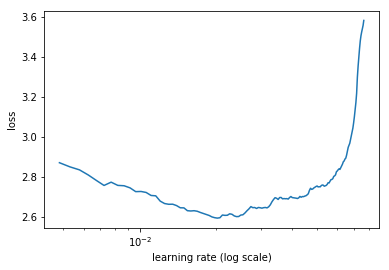

In [48]:
learner.sched.plot()

In [49]:
learner.save('lm_last_ft_after_lr_find')

In [50]:
learner.load('lm_last_ft_after_lr_find')

In [51]:
# Run this if you want to highly tune the LM to the Twitter posts data, with 15 epochs
# use_clr controls the shape of the cyclical (triangular) learning rate
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

epoch      trn_loss   val_loss   accuracy                   
    0      2.28737    2.03659    0.643056  
    1      2.064708   1.94871    0.656125                   
    2      1.86991    1.872811   0.667837                   
    3      1.735786   1.855831   0.674131                   
    4      1.632353   1.826983   0.680613                   
    5      1.562823   1.786965   0.684673                   
    6      1.461448   1.803529   0.687916                   
    7      1.360253   1.832769   0.691121                   
    8      1.293308   1.808667   0.694983                   
    9      1.202396   1.851651   0.69703                    
    10     1.11245    1.861551   0.699506                   
    11     1.069887   1.859176   0.701969                   
    12     0.998587   1.88491    0.702887                    
    13     0.947622   1.896402   0.704545                    
    14     0.876249   1.912582   0.705272                    



[array([ 1.91258]), 0.70527243809567552]

In [52]:
# Save the Backbone for further classification!!
learner.save('lm1')
learner.save_encoder('lm1_enc')

In [53]:
learner.load_encoder('lm1_enc')
learner.load('lm1')

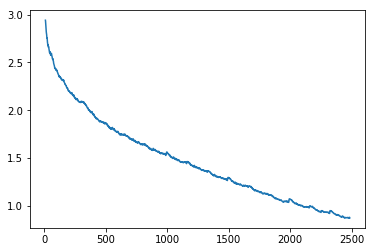

In [54]:
learner.sched.plot_loss()

# Going back to classification!

Now that we spent some time fine-tuning the language model on our Twitter data, let's see if we can classify easily these reviews.
As before, some cells should be run once, and then use data loaders for later use.

In [55]:
# df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
# df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)
df_trn = pd.read_json(
    f'{CLAS_PATH}/{data_file_nonextension_name}_train.json.gz', 
    orient='records', 
    lines=True, compression='gzip', chunksize=chunksize
)# [['text', 'labels']]

df_val = pd.read_json(
    f'{CLAS_PATH}/{data_file_nonextension_name}_test.json.gz', 
    orient='records', 
    lines=True, compression='gzip', chunksize=chunksize
)# [['text', 'labels']]

In [56]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
4
0
1


In [57]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [58]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

6020

In [59]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

# Classifier
In this part, we adopt an unusual train/test hierarchy. While it's common to train on a big dataset and thewn test on a small one, here we wanrt to test the hypothesis that the model can learn with few training data. Hence we take less data for training than for testing.

In [60]:
# The train data contains 28664 examples
# The test data contains 9555 examples

In [61]:
# We select here the 'size' first reviews of our dataset
# The paper claims that it's possible to achieve very good results with few labeled examples
# So let's try with 100 examples for training, and 5000 examples for validation.
# We encourage you to try different values to see the effect of data size on performance.
# trn_size = 1000
# val_size = 3517

In [62]:
trn_size = 1000
val_size = 5000

In [63]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

train = random.sample(list(zip(trn_clas, trn_labels)), trn_size)
trn_clas = np.array([item[0] for item in train])
trn_labels = np.array([item[1] for item in train])
del train

validation = random.sample(list(zip(val_clas, val_labels)), val_size)
val_clas = np.array([item[0] for item in validation])
val_labels = np.array([item[1] for item in validation])
del validation


bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [64]:
# Ccheck that the validation dataset is well balanced so acccuracy is a good metric
# We'll also check other metrics usual for binary classification (precision, recall, f1 score)
len(trn_labels[trn_labels == 1]) / len(trn_labels)

0.704

In [65]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)

In [66]:
# We define the model, here it a classifier on top of an RNN language model
# We load the language model encoder that we fine tuned before
# We freeze everything but the last layer, so that we can train the classification layer only.
#load the saved weights from before, and freeze everything until the last layer
# from fastai.lm_rnn import *

md = ModelData(PATH, trn_dl, val_dl)
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

lr=8*1e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [67]:
learn.freeze_to(-1)

In [68]:
# trn_size = 1000
# val_size = 5000
learn.lr_find(lrs/1000)

 83%|████████▎ | 35/42 [00:00<00:00, 43.14it/s, loss=3.52] 


In [32]:
# trn_size = 100
# val_size = 5000
learn.lr_find(lrs/1000)

epoch      trn_loss   val_loss   accuracy                
    0      0.715853   126.110563 0.630904  



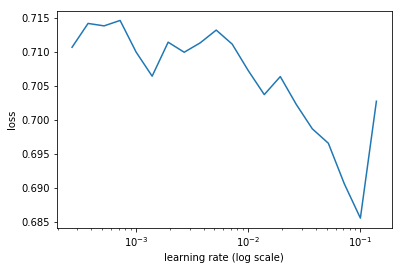

In [69]:
learn.sched.plot()

In [70]:
# Run one epoch on the classification layer
# trn_size = 1000
# val_size = 5000
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                  
    0      0.558563   0.571166   0.706788  



[array([ 0.57117]), 0.70678843013834358]

In [34]:
# Run one epoch on the classification layer
# trn_size = 100
# val_size = 5000
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                
    0      0.761598   0.66294    0.630888  



[array([ 0.66294]), 0.63088820578044869]

In [71]:
# Save the trained model
learn.save('clas_0')
learn.load('clas_0')

In [72]:
# Gradually unfreeze another layer to train a bit more parameters than just the classifier layer
# trn_size = 1000
# val_size = 5000
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                  
    0      0.520153   0.511702   0.74617   



[array([ 0.5117]), 0.74616973731746905]

In [36]:
# Gradually unfreeze another layer to train a bit more parameters than just the classifier layer
# trn_size = 100
# val_size = 5000
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                
    0      0.655339   0.663206   0.63076   



[array([ 0.66321]), 0.63075985164196158]

In [73]:
# Save the trained model
learn.save('clas_1')
learn.load('clas_1')

In [74]:
# Unfreeze everything and train for a few epochs on the whole set of parameters of the model
# trn_size = 1000
# val_size = 5000
learn.unfreeze()
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                  
    0      0.529359   0.500066   0.72519   
    1      0.533668   0.495438   0.745237                  
    2      0.529154   0.507092   0.735785                  
    3      0.501329   0.512533   0.743098                  
    4      0.509874   0.482353   0.755503                  
    5      0.509245   0.529652   0.721945                  
    6      0.493518   0.506739   0.747093                  
    7      0.485207   0.497019   0.750777                  
    8      0.472359   0.490957   0.760001                  
    9      0.471505   0.494154   0.753547                  
    10     0.465717   0.494152   0.752953                  
    11     0.462629   0.511418   0.759205                  
    12     0.447935   0.508651   0.760485                  
    13     0.444109   0.510728   0.75863                   



[array([ 0.51073]), 0.7586295151720972]

In [38]:
# Unfreeze everything and train for a few epochs on the whole set of parameters of the model
# trn_size = 100
# val_size = 5000
learn.unfreeze()
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                
    0      0.565184   0.658257   0.630736  
    1      0.609008   0.643067   0.641461                
    2      0.589626   0.629926   0.644149                
    3      0.582622   0.643003   0.634057                
    4      0.577048   0.674303   0.619072                
    5      0.561641   0.716868   0.607993                
    6      0.554197   0.673983   0.632581                
    7      0.529539   0.68012    0.64159                 
    8      0.538618   0.701428   0.633327                
    9      0.525071   0.738133   0.618959                
    10     0.502935   0.736744   0.620724                
    11     0.487381   0.719305   0.634891                
    12     0.501681   0.742144   0.632685                
    13     0.490324   0.749581   0.631273                



[array([ 0.74958]), 0.63127326669259676]

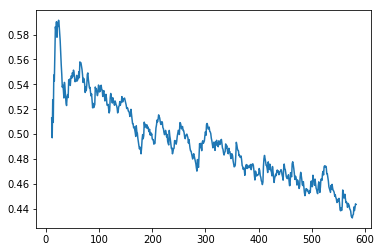

In [75]:
learn.sched.plot_loss()

In [76]:
# Save the model
learn.save('clas_2')

# Inference
Nonw, let's play with the model we've just learned!

In [77]:
c=int(trn_labels.max())+1
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

lr=8*1e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')
learn.load('clas_2')

In [78]:
def get_sentiment(input_str: str):

    # predictions are done on arrays of input.
    # We only have a single input, so turn it into a 1x1 array
    texts = [input_str]

    # tokenize using the fastai wrapper around spacy
    tok = [t.split() for t in texts]
    # tok = Tokenizer().proc_all_mp(partition_by_cores(texts))

    # turn into integers for each word
    encoded = [stoi[p] for p in tok[0]]

    idx = np.array(encoded)[None]
    idx = np.transpose(idx)
    tensorIdx = VV(idx)
    m.eval()
    m.reset()
    p = m.forward(tensorIdx)
    return np.argmax(p[0][0].data.cpu().numpy())

def prediction(texts):
    """Do the prediction on a list of texts
    """
    y = []
    
    for i, text in enumerate(texts):
        if i % 1000 == 0:
            print(i)
        encoded = text
        idx = np.array(encoded)[None]
        idx = np.transpose(idx)
        tensorIdx = VV(idx)
        m.eval()
        m.reset()
        p = m.forward(tensorIdx)
        y.append(np.argmax(p[0][0].data.cpu().numpy()))
    return y

In [79]:
sentence = "I like Feedly"
start = time()
print(get_sentiment(sentence))
print(time() - start)

1
0.005652666091918945


In [80]:
y = prediction(list(val_clas))

0
1000
2000
3000
4000


In [81]:
# Show relevant metrics for binary classification
# We encourage you to try training the classifier with different data size and its effect on performance
# trn_size = 1000
# val_size = 5000
print(f'Accuracy --> {accuracy_score(y, val_labels)}')
print(f'Precision --> {precision_score(y, val_labels)}')
print(f'F1 score --> {f1_score(y, val_labels)}')
print(f'Recall score --> {recall_score(y, val_labels)}')
print(confusion_matrix(y, val_labels))
print(classification_report(y, val_labels))

Accuracy --> 0.7712
Precision --> 0.896755994358251
F1 score --> 0.847507331378299
Recall score --> 0.8033864038412939
[[ 677  366]
 [ 778 3179]]
             precision    recall  f1-score   support

          0       0.47      0.65      0.54      1043
          1       0.90      0.80      0.85      3957

avg / total       0.81      0.77      0.78      5000



In [99]:
# Show relevant metrics for binary classification
# We encourage you to try training the classifier with different data size and its effect on performance
# trn_size = 100
# val_size = 5000
print(f'Accuracy --> {accuracy_score(y, val_labels)}')
print(f'Precision --> {precision_score(y, val_labels)}')
print(f'F1 score --> {f1_score(y, val_labels)}')
print(f'Recall score --> {recall_score(y, val_labels)}')
print(confusion_matrix(y, val_labels))
print(classification_report(y, val_labels))

Accuracy --> 0.7596
Precision --> 0.7835716288197365
F1 score --> 0.8230270906949352
Recall score --> 0.8666666666666667
[[1003  772]
 [ 430 2795]]
             precision    recall  f1-score   support

          0       0.70      0.57      0.63      1775
          1       0.78      0.87      0.82      3225

avg / total       0.75      0.76      0.75      5000



# What training size do we need?
The language model has already learnt a lot about the syntax. It is very knowledgeable about the context in which words appear in sentences. However, the language model does not contain any notion of [meaning](https://en.wikipedia.org/wiki/Meaning_%28linguistics%29). This problem is well summarised in [Emily Bender's tweet](https://twitter.com/emilymbender/status/1024042044035985408) during a very interesting twiter thread that occur in July around meaning in NLP. A cool summary of this thread can be found in the [Hugging Face](https://medium.com/huggingface/learning-meaning-in-natural-language-processing-the-semantics-mega-thread-9c0332dfe28e) blogpost. Hence the meaning in language is very likely to be learned through supervision, with the help of ground-truth examples.

However, when we perform some NLP tasks, sentiment analysis in our example, both syntax and meaning are important!
The idea is that you can save a lot of time by being taught with a lot of blind synatx first, and then learning meaning. Think of when you start learning a complete new field. Well, it is far easier to learn it in your mother tongue than in another language you master less. 

The big practical gain here is that once you "know" a language, you need less supervised examples to learn a new thing! In our example, it means we need less labeled reviews for us to learn a relevant classifier.

Let's verify this hypothesis by training a classifier with several training size and see how this size affects the performance!

In [100]:
# The train data contains 28664 examples
# The test data contains 9555 examples

In [82]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [83]:
def experiment(trn_size, val_size):

    train = random.sample(list(zip(trn_clas, trn_labels)), trn_size)
    aux_trn_clas = np.array([item[0] for item in train])
    aux_trn_labels = np.array([item[1] for item in train])
    del train

    validation = random.sample(list(zip(val_clas, val_labels)), val_size)
    aux_val_clas = np.array([item[0] for item in validation])
    aux_val_labels = np.array([item[1] for item in validation])
    del validation


    bptt,em_sz,nh,nl = 70,400,1150,3
    vs = len(itos)
    opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
    bs = 48

    min_lbl = aux_trn_labels.min()
    aux_trn_labels -= min_lbl
    aux_val_labels -= min_lbl
    c=int(aux_trn_labels.max())+1

    # Load data in relevant structures
    trn_ds = TextDataset(aux_trn_clas, aux_trn_labels)
    val_ds = TextDataset(aux_val_clas, aux_val_labels)
    trn_samp = SortishSampler(aux_trn_clas, key=lambda x: len(aux_trn_clas[x]), bs=bs//2)
    val_samp = SortSampler(aux_val_clas, key=lambda x: len(aux_val_clas[x]))
    trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
    val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)

    # Define the model and load the backbone lamguage model
    md = ModelData(PATH, trn_dl, val_dl)
    dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

    m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
              layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
              dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

    opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

    learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
    learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
    learn.clip=25.
    learn.metrics = [accuracy]

    lr=8*1e-3
    lrm = 2.6
    lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

    lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

    wd = 1e-7
    wd = 0
    learn.load_encoder('lm1_enc')

    learn.freeze_to(-1)

    # Find th learning rate
    learn.lr_find(lrs/1000)

    # Run one epoch on the classification layer
    learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

    # Save the trained model
    learn.save(f'{trn_size}clas_0')
    learn.load(f'{trn_size}clas_0')

    # Gradually unfreeze another layer to train a bit more parameters than just the classifier layer
    learn.freeze_to(-2)
    learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

    # Save the trained model
    learn.save(f'{trn_size}clas_1')
    learn.load(f'{trn_size}clas_1')

    # Unfreeze everything and train for a few epochs on the whole set of parameters of the model
    learn.unfreeze()
    learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

    # Save the model
    learn.sched.plot_loss()
    learn.save(f'{trn_size}clas_2')

##################################################
Experiment with training size 5000


 79%|███████▉  | 166/209 [00:03<00:00, 44.26it/s, loss=2.51] 


epoch      trn_loss   val_loss   accuracy                    
    0      0.536299   0.475285   0.738431  



epoch      trn_loss   val_loss   accuracy                    
    0      0.567444   0.490803   0.75472   



epoch      trn_loss   val_loss   accuracy                    
    0      0.533577   0.512736   0.757092  
    1      0.534065   0.467962   0.757646                    
    2      0.528081   0.505782   0.740959                    
    3      0.492988   0.472953   0.743662                    
    4      0.514707   0.453127   0.758924                    
    5      0.546      0.500951   0.759974                    
    6      0.494279   0.454799   0.764684                    
    7      0.500694   0.462029   0.758691                    
    8      0.496029   0.451828   0.768038                    
    9      0.456499   0.451427   0.771276                    
    10     0.490877   0.446977   0.777186                    
    11     0.478525   0.457053   0.763056                    
    12     0.473968   0.43951    0.770099                    
    13     0.470069   0.454124   0.760859                    

Time cost: 240.58250164985657
##################################################
Experi

 78%|███████▊  | 325/417 [00:07<00:02, 44.76it/s, loss=2.53] 


epoch      trn_loss   val_loss   accuracy                    
    0      0.530199   0.465706   0.757432  



epoch      trn_loss   val_loss   accuracy                    
    0      0.50456    0.471892   0.748323  



epoch      trn_loss   val_loss   accuracy                    
    0      0.551192   0.474074   0.754384  
    1      0.50504    0.482828   0.75157                     
    2      0.524796   0.443116   0.775373                    
    3      0.560574   0.452975   0.778183                    
    4      0.51089    0.438929   0.777488                    
    5      0.483623   0.453769   0.773351                    
    6      0.502594   0.44413    0.783607                    
    7      0.479295   0.463545   0.775699                    
    8      0.505682   0.44455    0.784759                    
    9      0.475343   0.460343   0.78544                     
    10     0.473579   0.479238   0.776239                    
    11     0.455412   0.455234   0.790136                    
    12     0.471648   0.504067   0.782018                    
    13     0.447873   0.471885   0.792469                    

Time cost: 406.81894087791443
##################################################
Experi

 79%|███████▉  | 949/1195 [00:19<00:05, 47.55it/s, loss=2.2]  

 43%|████▎     | 510/1195 [00:10<00:13, 50.26it/s, loss=0.552]

Exception in thread Thread-101:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.525063   0.458903   0.761894  



epoch      trn_loss   val_loss   accuracy                      
    0      0.498695   0.448076   0.765384  



epoch      trn_loss   val_loss   accuracy                      
    0      0.519452   0.449093   0.772248  
    1      0.47582    0.447455   0.779165                      
    2      0.489949   0.458134   0.785231                      
    3      0.449577   0.429594   0.799327                      
    4      0.450225   0.424896   0.799983                      
    5      0.45217    0.425148   0.804183                      
    6      0.466153   0.437424   0.791521                      
    7      0.493059   0.424387   0.80657                       
    8      0.511133   0.434952   0.806463                      
    9      0.447942   0.440594   0.808091                      
    10     0.431226   0.438728   0.803478                      
    11     0.468195   0.464022   0.808106                      
    12     0.461355   0.489492   0.809409                      
    13     0.454209   0.438863   0.810269                      

Time cost: 1010.9352300167084


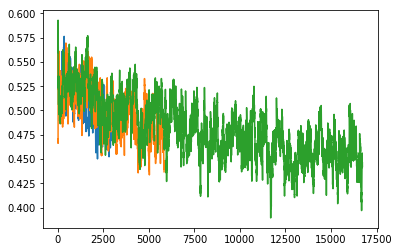

In [84]:
# The train data contains 28664 examples
# The test data contains 9555 examples
from time import time
val_size = 9555
for trn_size in [5000, 10000, 28664]:
    print('#'*50)
    print(f'Experiment with training size {trn_size}')
    start = time()
    experiment(trn_size, val_size)
    t = time() - start
    print(f'Time cost: {t}')

In [85]:
learn.load(f'28664clas_2')

In [86]:
y = prediction(list(val_clas))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [87]:
# trn_size = 28664
# val_size = 9555
print(f'Accuracy --> {accuracy_score(y, val_labels)}')
print(f'Precision --> {precision_score(y, val_labels)}')
print(f'F1 score --> {f1_score(y, val_labels)}')
print(f'Recall score --> {recall_score(y, val_labels)}')
print(confusion_matrix(y, val_labels))
print(classification_report(y, val_labels))

Accuracy --> 0.8125588697017269
Precision --> 0.8857481130679296
F1 score --> 0.8698495748855462
Recall score --> 0.8545117075956596
[[1779  772]
 [1019 5985]]
             precision    recall  f1-score   support

          0       0.64      0.70      0.67      2551
          1       0.89      0.85      0.87      7004

avg / total       0.82      0.81      0.82      9555



Some notebook issues here, you might want to run this cell from a python script...

In [88]:
y = prediction(list(val_clas)[:100])

0


In [89]:
print(f'Precision --> {precision_score(y, val_labels[:100])}')
print(f'F1 score --> {f1_score(y, val_labels[:100])}')
print(f'Recall score --> {recall_score(y, val_labels[:100])}')
print(confusion_matrix(y, val_labels[:100]))
print(classification_report(y, val_labels[:100]))

Precision --> 0.9428571428571428
F1 score --> 0.8979591836734694
Recall score --> 0.8571428571428571
[[19  4]
 [11 66]]
             precision    recall  f1-score   support

          0       0.63      0.83      0.72        23
          1       0.94      0.86      0.90        77

avg / total       0.87      0.85      0.86       100

